# Pedestrians recognition without using Deep Learning

# Dependencies

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import shutil
import glob
import matplotlib.image as mpimg
import random
from skimage import exposure
from skimage import feature


data_root = "img1"
BACK_SUB_FOLDER_PATH = "back_sub"
DATASET_SVM_PATH = "dataset_svm"
VIDEO_NAME = "apply_box"
MIN_HUMAN_RATIO = 1
MAX_HUMAN_RATIO = 5
MAX_RATIO_MERGE = MAX_HUMAN_RATIO

MAX_DIST_CONSIST = 10
N_CONSISTENCY = 1


gt_path = './gt/gt.txt'

_W = 1280
_H = 960
_N = 684 # number of frames

WIDTH_SAMPLE_SVM = 15
HEIGHT_SAMPLE_SVM = 30

print("Starting asquin.py / .ipynb")
print("Please be sure to have in the same folderthe 'gt' and 'img1' folders.")
print("The process leads to a SVM machine training along with pictures filters and extraction.")
print("Please be aware that folders are going to be create, sur as", BACK_SUB_FOLDER_PATH)
print("It may take up to 1 minutes. Thanks for waiting :)")

Starting asquin.py / .ipynb
Please be sure to have in the same folderthe 'gt' and 'img1' folders.
The process leads to a SVM machine training along with pictures filters and extraction.
Please be aware that folders are going to be create, sur as back_sub
It may take up to 1 minutes. Thanks for waiting :)


# Evaluation and dataset function

In [2]:
def format_id(frame):
    assert _N >= frame
    return '{:03d}'.format(frame)


def read_frame(root, frame):
    """Read frames and create integer frame_id-s"""
    assert _N >= frame
    return cv2.imread(os.path.join(root,format_id(frame)+'.jpg'), cv2.IMREAD_UNCHANGED)
    

def read_gt(filename):
    """Read gt and create list of bb-s"""
    assert os.path.exists(filename)
    with open(filename, 'r') as file:
        lines = file.readlines()
    # truncate data (last columns are not needed)
    return [list(map(lambda x: int(x), line.split(',')[:6])) for line in lines]


def annotations_for_frame(solution, frame):
    assert _N >= frame
    return [bb for bb in solution if int(bb[0])==int(frame)]


def evaluate_solution(gt, solution, N):
    """Caclulate evaluation metric"""
    score = []
    #for frame in [300]:
    for frame in range(1, N):
        bbs_sol = annotations_for_frame(solution, frame)
        bbs_gt = annotations_for_frame(gt, frame)
        black_sol = np.zeros((_H, _W))
        black_gt = np.zeros((_H, _W))
        for bb in bbs_sol:
            x, y = bb[2:4]
            dx, dy = bb[4:6]
            cv2.rectangle(black_sol, (x, y), (x+dx, y+dy), (255), -1)
        for bb in bbs_gt:
            x, y = bb[2:4]
            dx, dy = bb[4:6]
            cv2.rectangle(black_gt, (x, y), (x+dx, y+dy), (255), -1)
        # intersection over union
        intersection = black_sol * black_gt
        intersection[intersection > 0.5] = 1
        union = black_sol + black_gt
        union[union > 0.5] = 1
        if not union.any():
            continue
        score.append(intersection.sum()/union.sum())
        
        
    return np.asarray(score).mean()
    

def show_annotation(solution, frame):
    assert _N >= frame
    im = read_frame(data_root, frame)
    bbs = annotations_for_frame(solution, frame)
    for bb in bbs:
        x, y = bb[2:4]
        dx, dy = bb[4:6]
        cv2.rectangle(im, (x, y), (x+dx, y+dy), (0,255,0), 10)
    plt.imshow(im)
    plt.title('Annotations for frame {}.'.format(frame))
    plt.show()
    return

## Display image

In [3]:
def disp_image(im):
    """
    Just display an image using matplotlib pyplot
    :param im: image, np.array
    """
    
    imgplot = plt.imshow(im)
    plt.show()

## HOG function

In [4]:
def hog(im, disp=False):
    """
    Compute the HOG transformation of the image given in input
    :param im: image, np.array
    :param disp: bool, default=False, set to True to visualise the HOG transform
    """
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    if disp:
        # extract Histogram of Oriented Gradients from the logo
        (H, hogImage) = feature.hog(gray, 
                                    orientations=9, 
                                    pixels_per_cell=(2, 2),
                                    cells_per_block=(1, 1), 
                                    transform_sqrt=True, 
                                    block_norm="L1", 
                                    visualise=True)

        hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
        hogImage = hogImage.astype("uint8")

        disp_image(logo)
        disp_image(hogImage)
    else:
        H = feature.hog(gray, 
                        orientations=9, 
                        pixels_per_cell=(2, 2),
                        cells_per_block=(1, 1), 
                        transform_sqrt=True, 
                        block_norm="L1")
    
    return H
    
# im = cv2.imread("dataset_svm/002_0.jpg")
# hog(im, disp=True)

## Background substraction

In [5]:
def background_substraction(les_im_path, video_name=None, back_sub_folder="back_sub"):
    """
    Generate a video with background substraction
    :param les_im_path: list of string, images path
    :param video_name: string, default = None, if set, will save a video of the backgroud substraction to 'video_name'.avi
    :param back_sub_folder: string, default = 'back_sub', folder used to save background substracted images
    
    OUTPUT:
        back_sub/XXX.jpg : images of the background substraction
        
        if video_name != None:
            video_name.avi : video of the background substraction
    """
    print("Running background substraction:")
    # Create background frame
    fgbg = cv2.createBackgroundSubtractorMOG2()
    
    # Create output folder if doesn't already exist
    try:
        os.mkdir(back_sub_folder)
    except FileExistsError:
        pass
    
    if video_name is not None:
        # Get video size
        height,width,layers=cv2.imread(les_im_path[0]).shape

        # Create video object
        fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
        video = cv2.VideoWriter(video_name + '.avi', fourcc, fps=25, frameSize=(width,height), isColor=False)
    
    # Computing background
    for id_im, im_path in enumerate(les_im_path):
        print("#" + str(id_im), end="\r")
        im = cv2.imread(im_path)
        fgmask = fgbg.apply(im)
        
        cv2.imwrite(back_sub_folder + '/' + im_path.split("/")[-1], fgmask)
        
        if video_name is not None:
            # Writing frame to video
            video.write(fgmask)
    
    if video_name is not None:
        # Close video
        video.release()
    print("Done")

## Interface

In [6]:
class Interface:
    """
    Load in attributes useful data, such as images paths. 
    Also implement interfacing with background substraction or the apply box to video function
    
    :param data_root: string, where is the img dataset
    :param back_sub_folder: string, where should be stored the background substracted images
    """
    def __init__(self, data_root=data_root, back_sub_folder_path=BACK_SUB_FOLDER_PATH):
        self.dataset_path = data_root
        self.dataset_backsub_path = back_sub_folder_path
        self.les_im_path = self.get_dataset_im_path(self.dataset_path)
        self.les_im_backsub_path = self.get_dataset_im_path(self.dataset_backsub_path)
    
    def get_dataset_im_path(self, path):
        """
        Get images path using glob
        :param path: string, dataset folder
        :return les_im_path: list of string, lsit sorted of every .jpg file in the dataset
        """
        les_im_path = glob.glob(path + "/*.jpg")
        les_im_path.sort()
        return les_im_path
    
    def background_substraction(self):
        background_substraction(
            self.les_im_path, 
            video_name="backgroud_substraction", 
            back_sub_folder=self.dataset_backsub_path
        )
        self.les_im_backsub_path = self.get_dataset_im_path(self.dataset_backsub_path)
        
    def apply_box_to_video(self):
        apply_box_to_video(self.les_im_path, self.les_im_backsub_path)

interfacer = Interface()
interfacer.background_substraction()
# interfacer.apply_box_to_video()

Running background substraction:
Done


## Get human shaped contours

In [7]:
class Box:
    """
    Object to store a box by its boundaries (Point of min x and y, Point of max x and y)
    
    :param x_min: int, x minimal value of the box
    :param y_min: int, y minimal value of the box
    :param x_max: int, x maximal value of the box
    :param y_max: int, x maximal value of the box
    """
    def __init__(self, x_min, y_min, x_max, y_max):
        self.x_min = x_min
        self.y_min = y_min
        self.x_max = x_max
        self.y_max = y_max
    
    def __repr__(self):
        ret = "x_min: " + str(self.x_min) + ", y_min: " + str(self.y_min) + ", x_max: " + str(self.x_max) + ", y_max: " + str(self.y_max)
        return ret
    
    def is_overlap(self, other):
        """
        Check if 2 Box object are overlapping
        :param other: Box, the other box to evaluate a overlap with
        :return is_overlapping: True if the boxes are overlapping, False else.
        """
        return not (self.x_max < other.x_min or self.x_min > other.x_max or self.y_max < other.y_min or self.y_min > other.y_max)

        
def filter_ratio(box, ratio_min, ratio_max, disp=False):
    """
    Return the box if in ratio_min and ratio_max, return None else.
    :param box: the box to check
    :param ratio_min: minimum accepted ratio
    :param ratio_max: maximum accepted ratio
    """
    width = box.x_max - box.x_min
    height = box.y_max - box.y_min

    # ratio
    ratio = height / width

    if ratio > ratio_min and ratio < ratio_max:
        return box
    else:
        return None

        
def get_contours_human_ratio(im_path, disp=False):
    """
    Load the image, get the contour of the shape in it and check if they are human-shape like
    
    :param im_path: string, path to the background_substracted image to analyse.
    :param disp: bool, default=False, set to True to visualize the contours.
    :return les_potential_human_box: boxes that could be human like in shape (number_frame, box in this frame)
    
    """
    # Load image and resize witout changing ratio
    im = cv2.imread(im_path)
    height, width = im.shape[:2]
    new_width = 500
    new_height = new_width*height//width
    im = cv2.resize(im,(new_width, new_height), interpolation = cv2.INTER_CUBIC)
    
    # Change to gray and apply both gaussian and threshold filter
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    blurred_im = cv2.GaussianBlur(im_gray, (1, 1), 0)
    ret,thresh = cv2.threshold(blurred_im, 220, 255, 0)
    
    # Compute contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get dimension of main contours
    les_potential_human_box = []
    for cnt in contours:
        # Compute area size
        area = cv2.contourArea(cnt)
        if area > 3:
            # remove overdimension of contours
            cnt_low = cnt[:, 0]
            
            if disp:
                print(area)
                im2 = cv2.drawContours(im.copy(), cnt, -1, (255,0,0), 2)
                disp_image(im2)
    
            # contour width
            x_max = np.max(cnt_low[:, 0])*width//new_width
            x_min = np.min(cnt_low[:, 0])*width//new_width
            # contour height
            y_max = np.max(cnt_low[:, 1])*height//new_height
            y_min = np.min(cnt_low[:, 1])*height//new_height
            
            potential_human_box = filter_ratio(Box(x_min, y_min, x_max, y_max), 1, 5)
            if potential_human_box is not None:
                les_potential_human_box.append(potential_human_box)
            
    return les_potential_human_box
    
    
# a = get_contours_human_ratio(BACK_SUB_FOLDER_PATH + "/220.jpg", disp=False)

# SVM

In [8]:
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

class SVM:
    """
    Implement a SVM dataset preparation and a SVM training
    :param les_im_path: list of string, path to original images
    :param replace: bool, default=False, set to True to visualize the SVM dataset images
    :param load_in_ram: bool, default=True, store the dataset in the RAM
    """
    def __init__(self, les_im_path, replace=False, load_in_ram=True):
        self.gt = read_gt(gt_path)
        self.dataset_svm_path = DATASET_SVM_PATH
        self.dataset_svm_neg_path = self.dataset_svm_path + "_neg"
        self.replace = replace
        
        self.les_im_path = les_im_path
        self.load_in_ram = load_in_ram
        if self.load_in_ram:
            self.data = []
            self.labels = []
        
        if self.replace:
            # Remove dataseth
            if os.path.isdir(self.dataset_svm_path):
                shutil.rmtree(self.dataset_svm_path)
            # remove negative dataset
            if os.path.isdir(self.dataset_svm_neg_path):
                shutil.rmtree(self.dataset_svm_neg_path)
            
            # Create empty dataset folders
            os.mkdir(self.dataset_svm_path)
            os.mkdir(self.dataset_svm_neg_path)
    
    def write_random_areas(self, frame_path, frame, les_box):
        """
        For SVMs, we have to generate negative samples. 
        Thus, we need to generate images where there is not human.
        
        :param frame_path: string, path to the image
        :param les_box: box containing humans (boxes to avoid in the random areas generation)
        """
        frame_height, frame_width = frame.shape[:2]
        
        for id_box, box in enumerate(les_box):
            
            box_width = box.x_max - box.x_min
            box_height = box.y_max - box.y_min
            
            target_is_ok = False
            while not target_is_ok:
                x_min_target = random.randint(0, frame_width - box_width-1)
                y_min_target = random.randint(0, frame_height - box_height-1)
                
                box_target = Box(x_min_target, y_min_target, x_min_target + box_width, y_min_target + box_height)
                
                # Check if target box and other boxes are overlapping
                for box2 in les_box:
                    if not box2.is_overlap(box_target):
                        # Stopping while
                        target_is_ok = True
                        # get neg image crop
                    else:
                        # If overlap, break the for loop to not reach write specs and set false ok target
                        target_is_ok = False
                        break
                        
                im_crop = frame[box_target.y_min:box_target.y_max, box_target.x_min:box_target.x_max]
                im_crop = cv2.resize(im_crop,(WIDTH_SAMPLE_SVM,HEIGHT_SAMPLE_SVM))
                
                crop_path = self.dataset_svm_neg_path + '/' + frame_path.split("/")[-1].replace(".jpg", "_" + str(id_box) + ".jpg")
                if self.replace:
                    cv2.imwrite(crop_path, im_crop)

                if self.load_in_ram:
                    # self.negative.append(im_crop)
                    self.data.append(im_crop)
                    self.labels.append(0)

    
    def dataset_prepare(self):
        """
        SVM dataset preparation.
        Will extract humans in the dataset_svm_path and negative samples in the dataset_svm_path_neg folders
        with an image shape of (WIDTH_SAMPLE_SVM, HEIGHT_SAMPLE_SVM)
        """
        print("Extracting SVM dataset : positive (persons) and negative")
        for id_frame, frame_path in enumerate(self.les_im_path):
            print("Frame #" + str(id_frame), end="\r")
            bbs_gt = annotations_for_frame(self.gt, id_frame)
            black_gt = np.zeros((_H, _W))
            frame = cv2.imread(frame_path)
            
            les_box = []
            for id_bb, bb in enumerate(bbs_gt):
                x, y = bb[2:4]
                dx, dy = bb[4:6]
                les_box.append(Box(x, y, x+dx, y+dy))
                
                im_crop = frame[y:y+dy, x:x+dx]
                im_crop = cv2.resize(im_crop,(WIDTH_SAMPLE_SVM,HEIGHT_SAMPLE_SVM))
                
                crop_path = self.dataset_svm_path + '/' + frame_path.split("/")[-1].replace(".jpg", "_" + str(id_bb) + ".jpg")
                cv2.imwrite(crop_path, im_crop)
                if self.load_in_ram:
                    self.data.append(im_crop)
                    self.labels.append(1)
                
            self.write_random_areas(frame_path, frame, les_box)
        print("Done" + " "*20)
                
    def train(self, test_size=0.2):
        """
        Train the SVM after having applied a HOG transform to the images of the dataset.
        :param test_size: test size ratio of the test dataset to check the quality of the SVM classifier.
        """
        # Apply hog transform to images
        data_prep = np.array(list(map(hog, self.data)))
        labels_prep = np.array(self.labels)
        
        # Suffle the dataset
        data_prep, labels_prep = shuffle(data_prep, labels_prep, random_state=0)
        
        # Split in test and train
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            data_prep, labels_prep, test_size=test_size)
        
        print('Training data and target sizes: \n{}, {}'.format(self.X_train.shape, self.y_train.shape))
        print('Test data and target sizes: \n{}, {}'.format(self.X_test.shape, self.y_test.shape))
        
        self.classifier = svm.SVC(gamma="auto", verbose=True)
        #fit to the trainin data
        self.classifier.fit(self.X_train,self.y_train)
    
    def check_accuracy(self):
        y_pred = svm_trainer.classifier.predict(svm_trainer.X_test)
        print("Accuracy\n", metrics.classification_report(svm_trainer.y_test, y_pred))
        print("SVM accuracy:",metrics.accuracy_score(svm_trainer.y_test, y_pred))
        
        

svm_trainer = SVM(interfacer.les_im_path, replace = False, load_in_ram=True)
svm_trainer.dataset_prepare()

Extracting SVM dataset : positive (persons) and negative
Done                    


## Train and test SVM

In [9]:
svm_trainer.train()
svm_trainer.check_accuracy()

Training data and target sizes: 
(1859, 945), (1859,)
Test data and target sizes: 
(465, 945), (465,)
[LibSVM]Accuracy
               precision    recall  f1-score   support

           0       0.91      0.99      0.95       226
           1       0.99      0.91      0.95       239

   micro avg       0.95      0.95      0.95       465
   macro avg       0.95      0.95      0.95       465
weighted avg       0.95      0.95      0.95       465

SVM accuracy: 0.946236559139785


## Apply boxes to video

In [10]:
def merge_box(les_box):
    """
    Merge boxes that are near each others with one above the other.
    :param les_box: list of Box, boxes to check and merge
    :return les_new_box: list of merged boxes
    """
    # If a box is above another, merge
    to_process_box = les_box.copy()
    les_new_box = []
    while len(to_process_box) > 0:
        box = to_process_box.pop(0)
        # get x domain
        les_box_mate = []
        for box_mate in les_box:
            if box.x_max > box_mate.x_min and box_mate.x_max > box.x_min:
                les_box_mate.append(box_mate)
                # Remove the soon merged box mate from the list of "to merge" boxes
                try:
                    to_process_box.remove(box_mate)
                except ValueError:
                    pass
        if len(les_box_mate) != 0:
            # Get boundaries
            x_min_mate = min([box_mate.x_min for box_mate in les_box_mate])
            x_max_mate = max([box_mate.x_max for box_mate in les_box_mate])
            y_min_mate = min([box_mate.y_min for box_mate in les_box_mate])
            y_max_mate = max([box_mate.y_max for box_mate in les_box_mate])
            les_new_box.append(Box(x_min_mate, y_min_mate, x_max_mate, y_max_mate))
    
    return les_new_box


def inertia_consistency_box(les_whole_box, max_dist=5, n_consistency=1):
    """
    Check if there is an inertia in the box evolution: that means if they are in the neighborhood after
    a few frames.
    
    :param les_whole_box: list of Boxes to check
    :param max_dist: int, maximim distance between two boxes, between two frames, for the box to be kept
    :param n_consistency: int, default=1, set to n > 1 if you want a second check after n frames at distance n*max_dist.
    """
    print("Checking box inertia and consistancy")
    # looping to check consistency between boxes n and n-1
    # check if their is a box in the n+1 frame near to the box studied in the n frame
    assert n_consistency > 0
    
    les_whole_box_inertia = []
    for id_les_box in range(0, len(les_whole_box)-n_consistency):
        print("#" + str(id_les_box+1) + "/" + str(len(les_whole_box)), end="\r")
        les_box_inertia = []
        # get the study box
        for study_box in les_whole_box[id_les_box]:
            # init les_box list
            # compute center of studied box
            x = (study_box.x_max - study_box.x_min)/2
            y = (study_box.y_max - study_box.y_min)/2
            for target_box in les_whole_box[id_les_box+1]:
                # compute center of targeted box
                x_target = (target_box.x_max - target_box.x_min)/2
                y_target = (target_box.y_max - target_box.y_min)/2
                dist = np.linalg.norm( np.array([x, y]) - np.array([x_target, y_target]) )
                if dist < max_dist:
                    to_save = False
                    # if own a near n+1 frame box, keep the studied box
                    # if dual, check on second round
                    if n_consistency > 1:
                        for target_box_2 in les_whole_box[id_les_box+n_consistency]:
                            x_target_2 = (target_box_2.x_max - target_box_2.x_min)/2
                            y_target_2 = (target_box_2.y_max - target_box_2.y_min)/2
                            dist = np.linalg.norm( np.array([x, y]) - np.array([x_target_2, y_target_2]) )
                            if dist < max_dist*n_consistency:
                                to_save=True
                    else:
                        to_save=True
                        
                    if to_save:
                        les_box_inertia.append(study_box)
                        break            
        
        # Store last frame boxes
        les_whole_box_inertia.append(les_box_inertia)
    print("Done" + " "*20)
    return les_whole_box_inertia

def check_is_human_svm(im, box):
    """
    Use the SVM training to guess if the object in the image in the box is a human.
    :param im: image, np.array: original image to study
    :param box: Box, box that is outbounding the element to study
    :return pred_bool: bool, True if guess that object is human, False if suspect it's not human
    """
    
    im_crop = im[box.y_min:box.y_max, box.x_min:box.x_max]
    im_crop = cv2.resize(im_crop,(WIDTH_SAMPLE_SVM,HEIGHT_SAMPLE_SVM))
    x_prep = np.array(hog(im_crop)).reshape(1, -1)
    
    y_pred = svm_trainer.classifier.predict(x_prep)
    
    return y_pred[0] == 1


def apply_box_to_video(les_im_path, les_im_backsub_path, video_name="apply_box"):
    """
    Apply the filters and box functions, along with the SVM function, to generate the boxes and apply 
    them to a video for a better visualization
    
    :les_im_path: list of string, path to studied images
    :les_im_backsub_path: list of string, path to the background substracted images
    :video_name: string, name of the video to write in order to visualize the algorithms efficiency
    """
    
    height,width,layers=cv2.imread(les_im_path[0]).shape

    # Create video object
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    video = cv2.VideoWriter(video_name + '.avi', fourcc, fps=25, frameSize=(width,height))
    
    print("Computing boxes: ratio -> merging -> ratio")
    les_whole_box = []
    # Computing background
    for id_im, im_path in enumerate(les_im_path):
        print("#" + str(id_im+1) + "/" + str(len(les_im_path)), end="\r")
        im = cv2.imread(im_path)
        
        # Get box
        les_box = get_contours_human_ratio(les_im_backsub_path[id_im])
        
        # Merge box
        merged_box = merge_box(les_box)
        
        # Get ride of out of ratio boxes
        les_merged_ratio_box = []
        for box in merged_box:
            merged_ratio_box = filter_ratio(box, MIN_HUMAN_RATIO, MAX_HUMAN_RATIO)
            if merged_ratio_box is not None:
                if check_is_human_svm(im, box):
                    les_merged_ratio_box.append(merged_ratio_box)
        
        les_whole_box.append(les_merged_ratio_box)
    print("Done" + " "*20)
    
    # les_whole_box = inertia_consistency_box(les_whole_box, max_dist=MAX_DIST_CONSIST, n_consistency=N_CONSISTENCY)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    print("Writing video")
    for id_les_box, les_box in enumerate(les_whole_box):
        print("#" + str(id_les_box+1) + "/" + str(len(les_whole_box)), end="\r")
        # write box into image
        im = cv2.imread(les_im_path[id_les_box])
        # Write frame id in im
        cv2.putText(im, str(id_les_box),(10,height), font, 3,(255,255,255),2,cv2.LINE_AA)
        for box in les_box:
            cv2.rectangle(
                im, 
                (box.x_min, box.y_min), 
                (box.x_max, box.y_max),
                (255, 0, 0),
                3
            )

        # write image to video
        video.write(im)
    video.release()
    print("Done" + " "*20)
    
    return les_whole_box
    

## Interface function

In [11]:
def pedestrians(data_root, _W, _H, _N):
    ''' Return a list of bounding boxes in the format frame, bb_id, x,y,dx,dy '''
    
    if not os.path.isdir(BACK_SUB_FOLDER_PATH):
        # Generate back sub folder
        pass
    
    interface = Interface(data_root, BACK_SUB_FOLDER_PATH)
    # print(interface.les_im_path)
    
    les_wholes_box_id = apply_box_to_video(
        les_im_path=interface.les_im_path, 
        les_im_backsub_path=interface.les_im_backsub_path,
        video_name=VIDEO_NAME)
    
    # Putting in format asked by evaluation function
    les_pedestrians = []
    for id_frame, frame_boxes in enumerate(les_wholes_box_id):
        for id_box, box in enumerate(frame_boxes):
            pedestrian = [id_frame+1, id_box+1, box.x_min, box.y_min, box.x_max-box.x_min, box.y_max-box.y_min]
            les_pedestrians.append(pedestrian)
    
    return les_pedestrians

## N.Evaluation

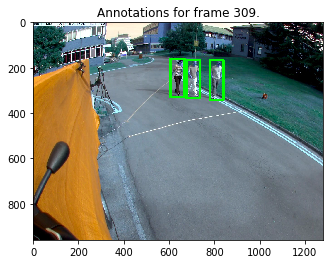

A perfect score... 1.0
Computing boxes: ratio -> merging -> ratio
Done                    
Writing video
Done                    
A great score! 0.3788544778722672


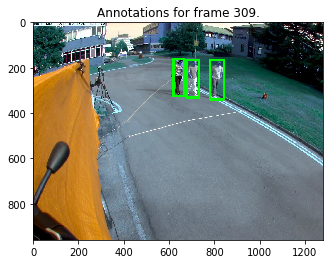

In [12]:
SCORING = True
if SCORING:
    gt = read_gt(gt_path)
    check_id = 309
    show_annotation(gt, check_id)

    print('A perfect score... {}'.format(evaluate_solution(gt, gt, _N)))

    # your solution will be tested simply by changing the dataset
    # and changing the module, i.e., the following has to work 
    # with simply using your module 
    sol = pedestrians(data_root, _W, _H, _N)
    print('A great score! {}'.format(evaluate_solution(sol, gt, _N)))
    show_annotation(sol, check_id)


## Generate new pedestrian dataset

In [13]:
import struct

def read_seq(path):
    
    def read_header(ifile):
        feed = ifile.read(4)
        norpix = ifile.read(24)
        version = struct.unpack('@i', ifile.read(4))
        length = struct.unpack('@i', ifile.read(4))
        assert(length != 1024)
        descr = ifile.read(512)
        params = [struct.unpack('@i', ifile.read(4))[0] for i in range(0,9)]
        fps = struct.unpack('@d', ifile.read(8))
        # skipping the rest
        ifile.read(432)
        image_ext = {100:'raw', 102:'jpg',201:'jpg',1:'png',2:'png'}
        return {'w':params[0],'h':params[1],
                'bdepth':params[2],
                'ext':image_ext[params[5]],
                'format':params[5],
                'size':params[4],
                'true_size':params[8],
                'num_frames':params[6]}
    
    ifile = open(path, 'rb')
    params = read_header(ifile)
    bytes = open(path, 'rb').read()

    # this is freaking magic, but it works
    extra = 8
    s = 1024
    seek = [0]*(params['num_frames']+1)
    seek[0] = 1024
    
    images = []
    
    for i in range(0, params['num_frames']-1):
        tmp = struct.unpack_from('@I', bytes[s:s+4])[0]
        s = seek[i] + tmp + extra
        if i == 0:
            val = struct.unpack_from('@B', bytes[s:s+1])[0]
            if val != 0:
                s -= 4
            else:
                extra += 8
                s += 8
        seek[i+1] = s
        nbytes = struct.unpack_from('@i', bytes[s:s+4])[0]
        I = bytes[s+4:s+nbytes]
        
        tmp_file = '/tmp/img%d.jpg' % i
        open(tmp_file, 'wb+').write(I)
        
        img = cv2.imread(tmp_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images

# a = read_seq("dataset/set00/V000.seq")

In [14]:
# disp_image(a[800])

In [15]:
import os
import glob
import json
from scipy.io import loadmat
from collections import defaultdict

def read_annot():
    all_obj = 0
    
    for dname in sorted(glob.glob('dataset/annotations/set*')):
        data = defaultdict(dict)
        set_name = os.path.basename(dname)
        data[set_name] = defaultdict(dict)
        for anno_fn in sorted(glob.glob('{}/*.vbb'.format(dname))):
            vbb = loadmat(anno_fn)
            nFrame = int(vbb['A'][0][0][0][0][0])
            objLists = vbb['A'][0][0][1][0]
            maxObj = int(vbb['A'][0][0][2][0][0])
            objInit = vbb['A'][0][0][3][0]
            objLbl = [str(v[0]) for v in vbb['A'][0][0][4][0]]
            objStr = vbb['A'][0][0][5][0]
            objEnd = vbb['A'][0][0][6][0]
            objHide = vbb['A'][0][0][7][0]
            altered = int(vbb['A'][0][0][8][0][0])
            log = vbb['A'][0][0][9][0]
            logLen = int(vbb['A'][0][0][10][0][0])

            video_name = os.path.splitext(os.path.basename(anno_fn))[0]
            data[set_name][video_name]['nFrame'] = nFrame
            data[set_name][video_name]['maxObj'] = maxObj
            data[set_name][video_name]['log'] = log.tolist()
            data[set_name][video_name]['logLen'] = logLen
            data[set_name][video_name]['altered'] = altered
            data[set_name][video_name]['frames'] = defaultdict(list)

            n_obj = 0
            for frame_id, obj in enumerate(objLists):
                if len(obj) > 0:
                    for id, pos, occl, lock, posv in zip(
                            obj['id'][0], obj['pos'][0], obj['occl'][0],
                            obj['lock'][0], obj['posv'][0]):
                        keys = obj.dtype.names
                        id = int(id[0][0]) - 1  # MATLAB is 1-origin
                        pos = pos[0].tolist()
                        occl = int(occl[0][0])
                        lock = int(lock[0][0])
                        posv = posv[0].tolist()

                        datum = dict(zip(keys, [id, pos, occl, lock, posv]))
                        datum['lbl'] = str(objLbl[datum['id']])
                        datum['str'] = int(objStr[datum['id']])
                        datum['end'] = int(objEnd[datum['id']])
                        datum['hide'] = int(objHide[datum['id']])
                        datum['init'] = int(objInit[datum['id']])
                        data[set_name][video_name][
                            'frames'][frame_id].append(datum)
                        n_obj += 1

            print(dname, anno_fn, n_obj)
            all_obj += n_obj
        
        print(data)

#     print('Number of objects:', all_obj)
#     json.dump(data, open('data/annotations.json', 'w'))
#     return data

# data = read_annot()